#### Questions:
#### How to interpret beer style coefficients in the regression model (as one categorical model, do not remove beer styles)
#### If we use beer style, should we balance out the samples (remove top 5 and bottom 5 beers) (no)

#### Group beer styles by type of yeast used? (ale, lager, hybrid)
#### Ales are fermented quicker, are more aromatic, and fruity
#### Lagers are fermented slower and at lower temperatures to create a "hoppy" taste
#### Hybrids are a combination of ale and lager
#### https://www.beeradvocate.com/beer/style/

#### How to select columns to use in regression? Lasso technique?
#### Split sentiment for sentiment by sentence. Find sentences with synonyms for each rating dimension
#### create aroma sentiment, appearance sentiment, etc...
#### interaction between age and beer style

In [76]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import webcolors

from datetime import datetime
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold

from textblob import TextBlob, Word

Baseline features
1. beer/ABV - the alcohol by volume of the beer
2. beer/style
3. user's gender
4. user's age in years

Extra features from review text
1. sentiment of the review
2. adjectives
3. adverbs
4. verbs
4. colors

#### Filling in missing values 
#### birthdays use average age
#### beer style use an empty string
#### review/text use an empty string

In [126]:
df = pd.DataFrame.from_csv('train.csv')
ratings = ['review/appearance','review/aroma','review/overall','review/palate','review/taste']
df.head()

,beer/ABV,beer/beerId,beer/brewerId,beer/name,beer/style,review/appearance,review/aroma,review/overall,review/palate,review/taste,review/text,review/timeStruct,review/timeUnix,user/ageInSeconds,user/birthdayRaw,user/birthdayUnix,user/gender,user/profileName
index,,,,,,,,,,,,,,,,,,
40163,5.0,46634,14338,Chiostro,Herbed / Spiced Beer,4.0,4.0,4.0,4.0,4.0,Pours a clouded gold with a thin white head. N...,"{'min': 38, 'hour': 3, 'mday': 16, 'sec': 10, ...",1229398690,NaN,NaN,NaN,NaN,RblWthACoz
8135,11.0,3003,395,Bearded Pat's Barleywine,American Barleywine,4.0,3.5,3.5,3.5,3.0,12oz bottle into 8oz snifter.\t\tDeep ruby red...,"{'min': 38, 'hour': 23, 'mday': 8, 'sec': 58, ...",1218238738,NaN,NaN,NaN,NaN,BeerSox
10529,4.7,961,365,Naughty Nellie's Ale,American Pale Ale (APA),3.5,4.0,3.5,3.5,3.5,First enjoyed at the brewpub about 2 years ago...,"{'min': 7, 'hour': 18, 'mday': 26, 'sec': 2, '...",1101492422,NaN,NaN,NaN,Male,mschofield
44610,4.4,429,1,Pilsner Urquell,Czech Pilsener,3.0,3.0,2.5,3.0,3.0,First thing I noticed after pouring from green...,"{'min': 7, 'hour': 1, 'mday': 20, 'sec': 5, 'y...",1308532025,1.209827e+09,"Aug 10, 1976",208508400.0,Male,molegar76
37062,4.4,4904,1417,Black Sheep Ale (Special),English Pale Ale,4.0,3.0,3.0,3.5,2.5,A: pours an amber with a one finger head but o...,"{'min': 51, 'hour': 6, 'mday': 12, 'sec': 48, ...",1299912708,NaN,NaN,NaN,NaN,Brewbro000


In [3]:
def convertUnixTimeToYears(unixTimes):
    ageInYears = []
    today = datetime.now()

    for age in unixTimes:
        birthdate = datetime.fromtimestamp(int(age))
        delta = today - birthdate
        years = delta.days / 365
        ageInYears.append(years)

    return (ageInYears)

### Baseline features EDA

### Pre-processing
Removed nan rows

Remove rows where beer style is 'K\xc3\x83\xc2\xb6lsch' (not an actual style?)

Convert user/birthdayUnix to age in years

### Descriptive Stats

#### Reviewers
7585 Males, 114 Females, 7699 participants total

Oldest person was 116 years old?

Youngest person was 25 years old

Average age was 39.4 years

~95% of the reviewers were about 30-50 years old

#### Beers
Average ABV is 7.466%, Min ABV is 0.5%, Max is 39.44%

~95% of the beers were between about 5-9% ABV

87 unique different kinds of beers

Top 5 were: American Double / Imperial Stout (969), American IPA (653), American Double / Imperial IPA (642),
Scotch Ale / Wee Heavy (458), Russian Imperial Stout (419)

Bottom 5 were: Kristalweizen (1), English Dark Mild Ale (1), Eisbock (1), Chile Beer (2), 
Braggot (2), California Common / Steam Beer (2), Dortmunder / Export Lager (2)

#### Ratings
Average ratings were about 3.9

Standard deviations were 0.67 - 0.71

Taste had the most variations in ratings

Most people rated between 3.2 - 4.6 (mostly high ratings, most people did not give bad reviews)

In [129]:
base = df[['beer/ABV','beer/style','user/gender', 'user/birthdayUnix', 'review/appearance','review/aroma',
           'review/overall','review/palate','review/taste', 'review/text']].dropna()
base = base[base['beer/style'] != 'K\xc3\x83\xc2\xb6lsch']
base['userAgeInYears'] = convertUnixTimeToYears(base['user/birthdayUnix'])
base = base.drop(['user/birthdayUnix'], axis=1)

base.describe()

,beer/ABV,review/appearance,review/aroma,review/overall,review/palate,review/taste,userAgeInYears
count,7699.000000,7699.000000,7699.000000,7699.000000,7699.000000,7699.000000,7699.000000
mean,7.466111,3.911872,3.897584,3.911482,3.866087,3.952526,39.378880
std,2.306563,0.591570,0.671391,0.699527,0.668865,0.714363,9.784571
min,0.500000,1.000000,1.000000,1.000000,1.000000,1.000000,25.000000
25%,5.500000,3.500000,3.500000,3.500000,3.500000,3.500000,33.000000
50%,7.000000,4.000000,4.000000,4.000000,4.000000,4.000000,37.000000
75%,9.400000,4.500000,4.500000,4.500000,4.500000,4.500000,43.000000
max,39.440000,5.000000,5.000000,5.000000,5.000000,5.000000,116.000000


In [5]:
print (base[base['user/gender'] == 'Male'].count())
print (base[base['user/gender'] == 'Female'].count())

beer/ABV             7585
beer/style           7585
user/gender          7585
review/appearance    7585
review/aroma         7585
review/overall       7585
review/palate        7585
review/taste         7585
review/text          7585
userAgeInYears       7585
dtype: int64
beer/ABV             114
beer/style           114
user/gender          114
review/appearance    114
review/aroma         114
review/overall       114
review/palate        114
review/taste         114
review/text          114
userAgeInYears       114
dtype: int64


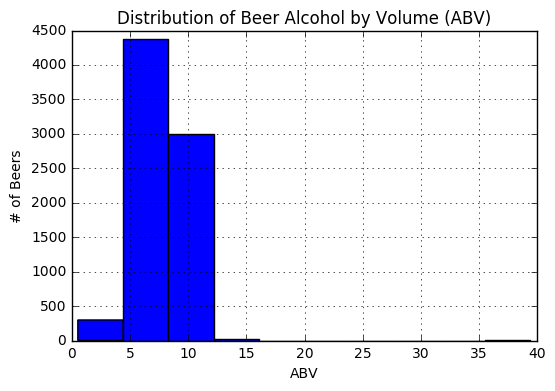

In [6]:
plt.hist(base['beer/ABV'])
plt.title('Distribution of Beer Alcohol by Volume (ABV)')
plt.xlabel('ABV')
plt.ylabel('# of Beers')
plt.grid(True)
plt.show()

In [7]:
len(base['beer/style'].unique())

87

In [128]:
base['beer/style'].value_counts()[base['beer/style'].value_counts() > 100]

American Double / Imperial Stout       4495
American IPA                           3050
American Double / Imperial IPA         2872
Scotch Ale / Wee Heavy                 2133
Russian Imperial Stout                 2032
American Pale Ale (APA)                1711
American Porter                        1687
Rauchbier                              1462
Rye Beer                               1355
Czech Pilsener                         1131
Fruit / Vegetable Beer                 1021
English Pale Ale                        971
Old Ale                                 783
Doppelbock                              669
American Barleywine                     634
Euro Pale Lager                         522
Extra Special / Strong Bitter (ESB)     506
Munich Helles Lager                     489
American Amber / Red Ale                489
Hefeweizen                              477
American Stout                          457
German Pilsener                         450
Belgian Strong Pale Ale         

In [9]:
base['beer/style'].value_counts()[base['beer/style'].value_counts() < 20]

English Stout                          19
Bock                                   19
American Pale Wheat Ale                18
Irish Dry Stout                        18
Quadrupel (Quad)                       17
Munich Dunkel Lager                    17
Irish Red Ale                          16
Belgian Strong Dark Ale                15
English Barleywine                     14
Belgian Pale Ale                       13
Smoked Beer                            12
Belgian IPA                            11
Herbed / Spiced Beer                   10
American Wild Ale                      10
Dunkelweizen                            9
Oatmeal Stout                           8
Scottish Ale                            8
Foreign / Export Stout                  7
American Malt Liquor                    6
Milk / Sweet Stout                      6
Schwarzbier                             6
Keller Bier / Zwickel Bier              5
Scottish Gruit / Ancient Herbed Ale     5
Cream Ale                         

In [10]:
base.columns

Index([u'beer/ABV', u'beer/style', u'user/gender', u'review/appearance',
       u'review/aroma', u'review/overall', u'review/palate', u'review/taste',
       u'review/text', u'userAgeInYears'],
      dtype='object')

### Convert beer style and gender to numerical features via one-hot encoding
#### 91 features used

In [111]:
X = base[["beer/style", "user/gender", 'beer/ABV', 'userAgeInYears']]
X = pd.get_dummies(X, columns=["beer/style", "user/gender"], prefix=["style", "gender"])

In [112]:
X.head()

,beer/ABV,userAgeInYears,style_Altbier,style_American Adjunct Lager,style_American Amber / Red Ale,style_American Amber / Red Lager,style_American Barleywine,style_American Black Ale,style_American Blonde Ale,style_American Brown Ale,...,style_Scottish Ale,style_Scottish Gruit / Ancient Herbed Ale,style_Smoked Beer,style_Tripel,style_Vienna Lager,style_Wheatwine,style_Winter Warmer,style_Witbier,gender_Female,gender_Male
index,,,,,,,,,,,,,,,,,,,,,
44610,4.4,41,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
29757,7.2,41,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
35307,5.5,38,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
12702,6.0,41,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
42710,5.4,31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


#### simple linear regression on each rating with 5-fold cross validation
#### score results via negative mean squared error

In [13]:
results = {}
for rating in ratings:
    reg = LinearRegression()
    scores = cross_val_score(reg, X, base[rating], cv=5, scoring='neg_mean_squared_error')
    results[rating] = np.mean(scores)

print (results)

{'review/appearance': -0.26274201212955756, 'review/taste': -0.3559744063986045, 'review/palate': -0.32624347133334841, 'review/overall': -0.40371134487413735, 'review/aroma': -0.30635302539758658}


#### Use Lasso regression to select columns for the model
#### Re-evaluate model with 5-fold cross validation

In [103]:
def linear_regression_with_lasso(X, Y):
    results = {}
    coeffs = {}
    kf = KFold(n_splits=5)

    for rating in ratings:
        scores = []
        curr_coeffs = []
        y = Y[rating]

        # split into training/testing
        for train, test in kf.split(X):
            matX = X.as_matrix()
            matY = y.as_matrix()

            X_train, X_test, y_train, y_test = matX[train], matX[test], matY[train], matY[test]

            # grid search for an optimal alpha for lasso
            parameters = {'alpha':[1e-3,0.005, 0.01,0.02,0.03,0.04,0.05]}
            lasso = Lasso(0.01)
            clf = GridSearchCV(lasso, parameters)
            clf.fit(X_train, y_train)

            # select features from lasso regression
            lasso = clf.estimator.fit(X_train, y_train)
            model = SelectFromModel(lasso, prefit=True)

            # transform new feature set
            X_new_train = model.transform(X_train)
            X_new_test = model.transform(X_test)

            # train linear regression model on new features
            # score on negative mse
            reg = LinearRegression().fit(X_new_train, y_train)
            preds = reg.predict(X_new_test)
            mse = mean_squared_error(y_test, preds)
            scores.append(-mse)

            # retrieve original columns selected from lasso regression
            feature_idx = model.get_support()
            feature_name = X.columns[feature_idx]
            curr_coeffs.append(feature_name)

        coeffs[rating] = curr_coeffs[np.argmax(scores)]
        results[rating] = np.mean(scores)
        
    return (results, coeffs)

#### Using Lasso regression to select columns makes the model easier to interpret, but decreases performance??
#### 1. Gender is not an important predictor of rating, only 114 women in the group
#### 2. Age and ABV were important predictors for all ratings
#### 3. Rauchbier beers were important predictors of appearance, taste, and aroma (a dark and smoky German beer)
#### 4. Russian imperial stouts were important predictors of appearance, taste, palate, and overall rating (high ABV, dry, burnt chocolate 
#### taste)
#### 5. American double/imperial stout, American IPA, and Russian stouts were in the top 5 beers
#### 6. Rye Beer and Rauchbier were not in the top 5 beers but were still an important predictor of rating for all categories

In [15]:
results, coeffs = linear_regression_with_lasso(X, base)
for key in results:
    print ('RESULTS FOR {0}'.format(key))
    print ('MSE {0}'.format(results[key]))
    print ('COLUMNS {0}'.format(', '.join(sorted(coeffs[key]))))
    print ('\n')

RESULTS FOR review/appearance
MSE -0.284738415387
COLUMNS beer/ABV, style_American Double / Imperial Stout, style_American IPA, style_Rauchbier, style_Russian Imperial Stout, style_Rye Beer, userAgeInYears


RESULTS FOR review/taste
MSE -0.384348827335
COLUMNS beer/ABV, style_American Double / Imperial Stout, style_American IPA, style_American Porter, style_Euro Pale Lager, style_Rauchbier, style_Russian Imperial Stout, style_Rye Beer, userAgeInYears


RESULTS FOR review/palate
MSE -0.355510632395
COLUMNS beer/ABV, style_American Double / Imperial Stout, style_American IPA, style_American Porter, style_Euro Pale Lager, style_Russian Imperial Stout, style_Rye Beer, userAgeInYears


RESULTS FOR review/overall
MSE -0.432099982054
COLUMNS beer/ABV, style_American Double / Imperial Stout, style_American IPA, style_American Porter, style_Euro Pale Lager, style_Russian Imperial Stout, style_Rye Beer, userAgeInYears


RESULTS FOR review/aroma
MSE -0.332956572271
COLUMNS beer/ABV, style_America

#### Add review sentiments to features
#### polarity = how positive, neutral, or negative the review is
#### subjectivity = how biased the review is 

In [113]:
def extract_sentiment(corpus):
    sentiment = []
    
    for text in base['review/text']:
        sentiment.append(TextBlob(text).polarity)
    
    return sentiment

In [114]:
X['review_polarity'] = extract_sentiment(base['review/text'])

In [115]:
X.head()

,beer/ABV,userAgeInYears,style_Altbier,style_American Adjunct Lager,style_American Amber / Red Ale,style_American Amber / Red Lager,style_American Barleywine,style_American Black Ale,style_American Blonde Ale,style_American Brown Ale,...,style_Scottish Gruit / Ancient Herbed Ale,style_Smoked Beer,style_Tripel,style_Vienna Lager,style_Wheatwine,style_Winter Warmer,style_Witbier,gender_Female,gender_Male,review_polarity
index,,,,,,,,,,,,,,,,,,,,,
44610,4.4,41,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.272917
29757,7.2,41,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.277778
35307,5.5,38,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.237344
12702,6.0,41,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.196078
42710,5.4,31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.229091


#### Evaluate model by doing lasso regression first to pick out optimal features

In [116]:
results, coeffs = linear_regression_with_lasso(X, base)
for key in results:
    print ('RESULTS FOR {0}'.format(key))
    print ('MSE {0}'.format(results[key]))
    print ('COLUMNS {0}'.format(', '.join(sorted(coeffs[key]))))
    print ('\n')

RESULTS FOR review/appearance
MSE -0.273091480264
COLUMNS beer/ABV, review_polarity, style_American Double / Imperial Stout, style_American IPA, style_Light Lager, style_Russian Imperial Stout, style_Rye Beer, userAgeInYears


RESULTS FOR review/taste
MSE -0.341339064127
COLUMNS beer/ABV, review_polarity, style_American Double / Imperial Stout, style_American IPA, style_American Porter, style_Euro Pale Lager, style_Rauchbier, style_Russian Imperial Stout, style_Rye Beer, userAgeInYears


RESULTS FOR review/palate
MSE -0.328263347098
COLUMNS beer/ABV, review_polarity, style_American Double / Imperial Stout, style_American IPA, style_American Porter, style_Russian Imperial Stout, style_Rye Beer, userAgeInYears


RESULTS FOR review/overall
MSE -0.383327445188
COLUMNS beer/ABV, review_polarity, style_American Double / Imperial Stout, style_American IPA, style_American Porter, style_Russian Imperial Stout, style_Rye Beer, userAgeInYears


RESULTS FOR review/aroma
MSE -0.311910348486
COLUMNS

In [34]:
def linear_regression(X, Y):
    results = {}
    coeffs = {}
    kf = KFold(n_splits=5)

    for rating in ratings:
        scores = []
        curr_coeffs = []
        y = Y[rating]

        # split into training/testing
        for train, test in kf.split(X):
            matX = X.as_matrix()
            matY = y.as_matrix()

            X_train, X_test, y_train, y_test = matX[train], matX[test], matY[train], matY[test]
            
            # train linear regression model and
            # score on negative mse
            reg = LinearRegression().fit(X_train, y_train)
            preds = reg.predict(X_test)
            mse = mean_squared_error(y_test, preds)
            scores.append(-mse)

            # retrieve original columns selected from lasso regression
            curr_coeffs.append(reg.coef_)

        coeffs[rating] = np.mean( np.array(curr_coeffs), axis=0 )
        results[rating] = np.mean(scores)
        
    return (results, coeffs)

#### Add parts of spech and noun phrases to features
#### Use number of nouns, noun phrases, adjectives, verbs, and adverbs used in the review
#### Use sentiment of adjectives and noun phrases

In [117]:
# extracts parts of speech for a paragraph
# returns dictionary of lists containing words for each
# part of speech
def extract_pos(paragraph):
    text = TextBlob(paragraph)
    
    adjs = []
    
    nouns = []
    adverbs = []
    verbs = []
    
    noun_phrases = text.noun_phrases
    noun_phrase_sentiment = TextBlob(' '.join(noun_phrases)).polarity

    for word in text.tags:
        pos = Word(word[0].lower()).lemmatize()
        
        if (word[1] == 'JJ'):
            adjs.append(pos)

        if (word[1] == 'NN' or word[1] == 'NNP' or word[1] == 'NNPS'):
            nouns.append(pos)

        if (word[1] == 'RB'):
            adverbs.append(pos)

        if (word[1] == 'VB'):
            verbs.append(pos)
    
    adjs_sentiment = TextBlob(' '.join(adjs)).polarity
    
    return { 'JJ':adjs, 'NN':nouns, 'RB':adverbs, 'VB':verbs, 'NN_phrase': noun_phrases,
           'NN_phrases_sentiment': noun_phrase_sentiment, 'adjs_sentiment': adjs_sentiment}

In [118]:
adjs = []
nouns = []
adverbs = []
verbs = []
noun_phrases = []
noun_phrase_sentiment = []
adjs_sentiment = []

i = 0

for review in base['review/text']:
    pos = extract_pos(review)
    
    adjs.append(len(pos['JJ']))
    nouns.append(len(pos['NN']))
    adverbs.append(len(pos['RB']))
    verbs.append(len(pos['VB']))
    noun_phrases.append(len(pos['NN_phrase']))
    noun_phrase_sentiment.append(pos['NN_phrases_sentiment'])
    adjs_sentiment.append(pos['adjs_sentiment'])
    
    i += 1
    if (i % 100 == 0):
        print i
    
X['adjs'] = adjs
X['nouns'] = nouns
X['noun_phrases'] = noun_phrases
X['adverbs'] = adverbs
X['verbs'] = verbs
X['adjs_sentiment'] = adjs_sentiment
X['noun_phrase_sentiment'] = noun_phrase_sentiment

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600


In [119]:
X.head()

,beer/ABV,userAgeInYears,style_Altbier,style_American Adjunct Lager,style_American Amber / Red Ale,style_American Amber / Red Lager,style_American Barleywine,style_American Black Ale,style_American Blonde Ale,style_American Brown Ale,...,gender_Female,gender_Male,review_polarity,adjs,nouns,noun_phrases,adverbs,verbs,adjs_sentiment,noun_phrase_sentiment
index,,,,,,,,,,,,,,,,,,,,,
44610,4.4,41,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.272917,5,21,9,3,3,-0.012500,-0.200000
29757,7.2,41,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.277778,10,18,11,8,3,0.207143,0.422222
35307,5.5,38,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.237344,20,30,12,14,6,0.221944,0.400000
12702,6.0,41,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.196078,16,28,15,5,1,0.109091,0.045833
42710,5.4,31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.229091,10,21,8,6,6,0.194271,0.147222


In [120]:
results, coeffs = linear_regression_with_lasso(X, base)
for key in results:
    print ('RESULTS FOR {0}'.format(key))
    print ('MSE {0}'.format(results[key]))
    print ('COLUMNS {0}'.format(', '.join(sorted(coeffs[key]))))
    print ('\n')

RESULTS FOR review/appearance
MSE -0.271829172003
COLUMNS adjs, adjs_sentiment, adverbs, beer/ABV, noun_phrase_sentiment, noun_phrases, nouns, style_American Double / Imperial Stout, style_American IPA, style_Light Lager, style_Russian Imperial Stout, style_Rye Beer, userAgeInYears


RESULTS FOR review/taste
MSE -0.335937420621
COLUMNS adjs, adjs_sentiment, adverbs, beer/ABV, noun_phrase_sentiment, noun_phrases, nouns, review_polarity, style_American Double / Imperial Stout, style_American IPA, style_American Porter, style_Euro Pale Lager, style_Rauchbier, style_Russian Imperial Stout, style_Rye Beer, userAgeInYears, verbs


RESULTS FOR review/palate
MSE -0.325291718071
COLUMNS adjs, adjs_sentiment, adverbs, beer/ABV, noun_phrases, nouns, review_polarity, style_American Double / Imperial Stout, style_American Porter, style_Russian Imperial Stout, userAgeInYears, verbs


RESULTS FOR review/overall
MSE -0.379324392325
COLUMNS adjs, adjs_sentiment, adverbs, beer/ABV, noun_phrase_sentiment